In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from time import time
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
%pylab inline
import pickle
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

Populating the interactive namespace from numpy and matplotlib


In [2]:
with open('capstone_websites_data/X_sparse_10users.pkl', 'rb') as X_sparse_10users_pkl:
    X_sparse_10users = pickle.load(X_sparse_10users_pkl)
with open('capstone_websites_data/y_10users.pkl', 'rb') as y_10users_pkl:
    y_10users = pickle.load(y_10users_pkl)

In [3]:
X_sparse_10users.shape

(13084, 4914)

In [3]:
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_10users, y_10users, 
                                                      test_size=0.3, 
                                                     random_state=7, stratify=y_10users)

In [4]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=7)

In [5]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std ) # , 
                     # edgecolor='none', facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std ) # , 
                     # edgecolor='none', facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

In [8]:
from sklearn.neighbors import KNeighborsClassifier

In [9]:
knn = KNeighborsClassifier(n_neighbors=100, n_jobs=-1)

In [10]:
%%time
knn_cv_scores = cross_val_score (knn, X_train, y_train, cv=skf)

Wall time: 5.11 s


In [24]:
print (np.mean(knn_cv_scores))

0.530904072961


In [20]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=100, p=2,
           weights='uniform')

In [25]:
%%time

knn_valid_acc = accuracy_score(y_valid, knn.predict(X_valid) )

Wall time: 2.21 s


In [26]:
print (knn_valid_acc)

0.559857361182


In [29]:
from sklearn.ensemble import RandomForestClassifier

In [37]:
forest = RandomForestClassifier(n_estimators=100, random_state=7, oob_score=True, n_jobs=-1)

In [38]:
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=True, random_state=7,
            verbose=0, warm_start=False)

In [39]:
forest.oob_score_

0.70375627866346369

In [40]:
rf_valid_acc = accuracy_score(y_valid, forest.predict(X_valid) )

In [41]:
rf_valid_acc

0.71293937850229239

In [31]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [44]:
logit = LogisticRegression(random_state=7, n_jobs=-1)

In [45]:
%%time
logit_cv_scores = cross_val_score(logit, X_train, y_train, cv=skf)

Wall time: 908 ms


In [49]:
logit.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=7, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [50]:
logit_valid_acc = accuracy_score(y_valid, logit.predict(X_valid) )

In [52]:
print ("{} {}".format(round(np.mean(logit_cv_scores), 3), round(logit_valid_acc, 3)) )

0.737 0.757


In [53]:
%%time
logit_c_values1 = np.linspace(1e-4, 1e4, 10)

logit_grid_searcher1 = LogisticRegressionCV(Cs=logit_c_values1, multi_class='multinomial', cv=skf, random_state=7, n_jobs=-1 )

logit_grid_searcher1.fit(X_train, y_train)

Wall time: 16.7 s


In [73]:
logit_mean_cv_scores1 = list(logit_grid_searcher1.scores_.values())[0].mean(axis=0)

In [74]:
print (logit_mean_cv_scores1 )

[ 0.30017619  0.73006925  0.7279925   0.72253549  0.71904037  0.71631013
  0.71434281  0.71423399  0.71379751  0.71139571]


In [75]:
np.max(logit_mean_cv_scores1)

0.73006925316922866

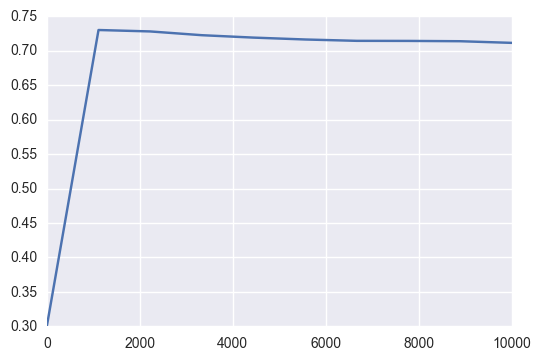

In [76]:
plot(logit_c_values1, logit_mean_cv_scores1);

In [77]:
%%time
logit_c_values2 = np.linspace(1e-3, 1, 30)

logit_grid_searcher2 = LogisticRegressionCV(Cs=logit_c_values2, multi_class='multinomial', cv=skf, random_state=7, n_jobs=-1 )

logit_grid_searcher2.fit(X_train, y_train)

Wall time: 38.2 s


In [78]:
logit_mean_cv_scores2 = list(logit_grid_searcher2.scores_.values())[0].mean(axis=0)

In [79]:
np.max(logit_mean_cv_scores2)

0.7359674596111736

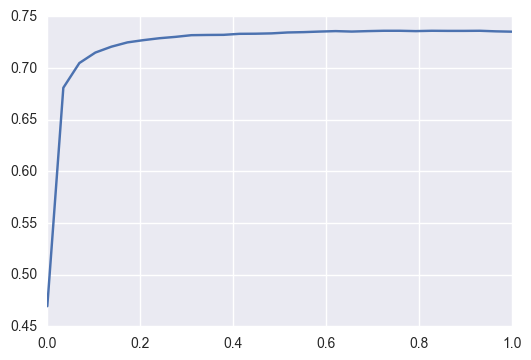

In [80]:
plot(logit_c_values2, logit_mean_cv_scores2);

In [88]:
C_best = logit_grid_searcher2.C_

In [89]:
logit_grid_searcher3 = LogisticRegressionCV(C_best, multi_class='multinomial', cv=skf, random_state=7, n_jobs=-1 )

In [90]:
logit_grid_searcher3.fit(X_train, y_train)

LogisticRegressionCV(Cs=array([ 0.82776,  0.82776,  0.82776,  0.82776,  0.82776,  0.82776,
        0.82776,  0.82776,  0.82776,  0.82776]),
           class_weight=None,
           cv=StratifiedKFold(n_splits=3, random_state=7, shuffle=True),
           dual=False, fit_intercept=True, intercept_scaling=1.0,
           max_iter=100, multi_class='multinomial', n_jobs=-1,
           penalty='l2', random_state=7, refit=True, scoring=None,
           solver='lbfgs', tol=0.0001, verbose=0)

In [91]:
logit_cv_acc = accuracy_score(y_valid, logit_grid_searcher3.predict(X_valid))

In [92]:
print ("{} {}".format(round(float(np.max(logit_mean_cv_scores2)), 3), 
                                    round(logit_cv_acc, 3)) )

0.736 0.753


In [7]:
from sklearn.svm import LinearSVC

In [8]:
svm = LinearSVC(C=1, random_state=7)

In [9]:
svm_cv_scores = cross_val_score(svm, X_train, y_train, cv=skf)

In [10]:
print (np.mean(svm_cv_scores) )

0.726681169533


In [15]:
svm.fit(X_train, y_train)

LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=7, tol=0.0001,
     verbose=0)

In [16]:
svm_acc_score = accuracy_score(y_valid, svm.predict(X_valid))

In [17]:
print (svm_acc_score)

0.751655629139


In [18]:
%%time
svm_params1 = {'C': np.linspace(1e-4, 1e4, 10)}

svm_grid_searcher1 = GridSearchCV(svm, svm_params1)
svm_grid_searcher1.fit(X_train, y_train)


Wall time: 49.4 s


In [19]:
svm_grid_searcher1.best_score_

0.66804979253112029

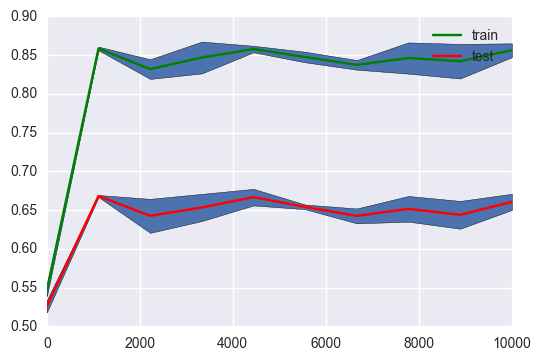

In [20]:
plot_validation_curves(svm_params1['C'], svm_grid_searcher1.cv_results_)

In [11]:
%%time
svm_params2 = {'C': np.linspace(1e-3, 1, 30)}

svm_grid_searcher2 = GridSearchCV(svm, svm_params2)
svm_grid_searcher2.fit(X_train, y_train)

Wall time: 1min 29s


In [151]:
svm_grid_searcher2.best_score_

0.73716968770473901

In [29]:
svm_grid_searcher2.best_estimator_

LinearSVC(C=0.10434482758620689, class_weight=None, dual=True,
     fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
     max_iter=1000, multi_class='ovr', penalty='l2', random_state=7,
     tol=0.0001, verbose=0)

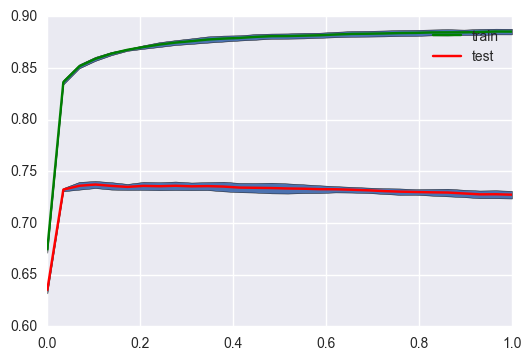

In [24]:
plot_validation_curves(svm_params2['C'], svm_grid_searcher2.cv_results_)

In [25]:
svm_cv_acc2 = accuracy_score(y_valid, svm_grid_searcher2.predict(X_valid))

In [28]:
print (svm_cv_acc2)

0.7633723892


In [12]:
def model_assessment(estimator, path_to_X_pickle, path_to_y_pickle, cv, 
                     random_state=7, test_size=0.3):
    '''
    Estimates CV-accuracy for (1 - test_size) share of (X_sparse, y) 
    loaded from path_to_X_pickle and path_to_y_pickle and holdout accuracy for (test_size) share of (X_sparse, y).
    The split is made with stratified train_test_split with params random_state and test_size.
    
    :param estimator – Scikit-learn estimator (classifier or regressor)
    :param path_to_X_pickle – path to pickled sparse X (instances and their features)
    :param path_to_y_pickle – path to pickled y (responses)
    :param cv – cross-validation as in cross_val_score (use StratifiedKFold here)
    :param random_state –  for train_test_split
    :param test_size –  for train_test_split
    
    :returns mean CV-accuracy for (X_train, y_train) and accuracy for (X_valid, y_valid) where (X_train, y_train)
    and (X_valid, y_valid) are (1 - test_size) and (testsize) shares of (X_sparse, y).
    '''
    with open(path_to_X_pickle, 'rb') as X_sparse_pkl:
        X_users = pickle.load(X_sparse_pkl)
    with open(path_to_y_pickle, 'rb') as y_pkl:
        y_users = pickle.load(y_pkl)
    X_tra, X_val, y_tra, y_val = train_test_split(X_users, y_users, test_size=test_size, 
                                                  random_state=random_state,  stratify=y_users)
                                                       
    cv_scores = cross_val_score(estimator, X_tra, y_tra, cv=cv)
    
    estimator.fit(X_tra, y_tra)
    acc_score = accuracy_score(y_val, estimator.predict(X_val))
    
    return np.mean(cv_scores), acc_score
    

In [13]:
model_assessment(svm_grid_searcher2.best_estimator_, 
                 'capstone_websites_data/X_sparse_10users.pkl',
                'capstone_websites_data/y_10users.pkl', skf, random_state=7, test_size=0.3)

(0.73607263868177386, 0.76337238920020378)

In [14]:
import itertools

In [21]:
def sparse_files_names(n_users, sess_len, win_size) :
    f1_name = 'capstone_websites_data/X_sparse_'+ str(n_users)+'users_s'+str(sess_len)+'_w'+str(win_size)+'.pkl' 
    f2_name = 'capstone_websites_data/y_'+str(n_users)+'users_s'+str(sess_len)+'_w'+str(win_size)+'.pkl'
    return f1_name, f2_name

In [23]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for num_users in [10]:
    for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
        if window_size <= session_length and (window_size, session_length) : # != (10, 10):
            
            print ("users=" +str(num_users) + " session length=" + 
                   str(session_length) + " window=" + str(window_size), end=" results= ")
            
            X_name, y_name  = sparse_files_names(num_users, session_length, window_size)
            
            v1, v2 = model_assessment(estimator, X_name, y_name, skf, random_state=7, test_size=0.3)
            
            print ("{} {}".format(round(v1, 3), round(v2, 3)) )

users=10 session length= 15  window= 10 results= 0.806 0.823
users=10 session length= 10  window= 10 results= 0.736 0.763
users=10 session length= 15  window= 7 results= 0.831 0.846
users=10 session length= 10  window= 7 results= 0.775 0.785
users=10 session length= 7  window= 7 results= 0.714 0.728
users=10 session length= 15  window= 5 results= 0.856 0.856
users=10 session length= 10  window= 5 results= 0.796 0.808
users=10 session length= 7  window= 5 results= 0.743 0.754
users=10 session length= 5  window= 5 results= 0.677 0.692
Wall time: 24.2 s


вывод: лучший результат классифаер выдает при размерах сессии - 15,  окна - 5

In [25]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for num_users in [150]:
    for window_size, session_length in [(5,5), (7,7), (10,10)]:
        if window_size <= session_length and (window_size, session_length):
            
            print ("users=" +str(num_users) + " session length=", session_length, " window=", window_size, end=" results= ")
            
            X_name, y_name  = sparse_files_names(num_users, session_length, window_size)
            
            v1, v2 = model_assessment(estimator, X_name, y_name, skf, random_state=7, test_size=0.3)
            
            print ("{} {}".format(round(v1, 3), round(v2, 3)) )
            

users=150 session length= 5  window= 5 results= 0.365 0.378
users=150 session length= 7  window= 7 results= 0.4 0.414
users=150 session length= 10  window= 10 results= 0.43 0.448
Wall time: 11min 38s


In [27]:
with open('capstone_websites_data/X_sparse_150users.pkl', 'rb') as X_sparse_150users_pkl:
     X_sparse_150users = pickle.load(X_sparse_150users_pkl)
with open('capstone_websites_data/y_150users.pkl', 'rb') as y_150users_pkl:
    y_150users = pickle.load(y_150users_pkl)

In [89]:
X_train_150, X_valid_150, y_train_150, y_valid_150 = train_test_split(X_sparse_150users, 
                                                                      y_150users, test_size=0.3, 
                                                     random_state=7, stratify=y_150users)

In [91]:
print (X_train_150.shape)

(91550, 27798)


In [32]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [41]:
Cs = [0.10434482758620689, 0.10434482758620689, 0.10434482758620689, 0.10434482758620689, 0.10434482758620689,
      0.10434482758620689, 0.10434482758620689, 0.10434482758620689, 0.10434482758620689, 0.10434482758620689 ]

In [38]:
%%time
logit_cv_150users = LogisticRegressionCV(Cs=Cs, multi_class='ovr', n_jobs=-1, random_state=7) 
logit_cv_150users.fit(X_train_150, y_train_150)

Wall time: 3min 41s


In [51]:
cv_scores_by_user = {}
for user_id in logit_cv_150users.scores_:
    mn = np.mean(logit_cv_150users.scores_[user_id])
    cv_scores_by_user[user_id] = mn
    print ( "{}:{}".format(user_id, round(mn, 3)), end = " ")

256:0.996 640:0.997 258:0.996 259:0.995 260:0.997 261:0.989 6:0.995 263:0.992 264:0.996 780:0.996 13:0.996 270:0.988 15:0.995 16:0.99 273:0.995 515:0.994 533:0.993 28:0.989 797:0.995 1054:0.996 31:0.994 1040:0.996 33:0.993 859:0.997 1798:0.995 294:0.996 39:0.986 298:0.99 812:0.994 301:0.997 46:0.997 49:0.995 50:0.994 563:0.997 308:0.995 53:0.993 568:0.992 564:0.995 570:0.998 315:0.997 573:0.991 318:0.995 575:0.989 576:0.994 65:0.997 66:0.995 580:0.985 2118:0.997 327:0.997 584:0.98 2355:0.994 332:0.997 333:0.996 269:0.987 82:0.996 339:0.997 340:0.996 85:0.996 342:0.992 569:0.989 344:0.997 89:0.99 603:0.995 92:0.994 605:0.996 351:0.992 784:0.996 356:0.997 102:0.991 103:0.978 600:0.991 361:0.997 106:0.993 363:0.996 677:0.996 1299:0.997 2902:0.996 118:0.99 105:0.996 120:0.994 126:0.995 127:0.99 128:0.985 2408:0.993 875:0.993 647:0.997 138:0.997 653:0.997 2191:0.995 664:0.995 665:0.997 411:0.99 692:0.997 158:0.997 160:0.997 417:0.997 932:0.989 165:0.997 425:0.994 2174:0.995 583:0.98 172:0.9

In [66]:
class_distr = np.bincount(y_train_150.astype('int'))
acc_diff_vs_constant = {}

for user_id in np.unique(y_train_150):
    x =  cv_scores_by_user[user_id] - (1. - float(class_distr[user_id])/len(y_train_150))
    acc_diff_vs_constant[user_id] = x
    # print (user_id, ":", (1. - float(class_distr[user_id])/len(y_train_150)), end = "  ")

In [67]:
num_better_than_default = (np.array(list(acc_diff_vs_constant.values())) > 0).sum()

In [71]:
z = float(num_better_than_default)/150.

In [72]:
print ( "{}".format(round(z, 3)) )

0.873


In [100]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(val_train, val_test, train_sizes, 
                        xlabel='Training Set Size', ylabel='score'):
    def plot_with_err(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
    plot_with_err(train_sizes, val_train, label='train')
    plot_with_err(train_sizes, val_test, label='valid')
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(loc='lower right');

In [101]:
y_binary_128 = np.asarray([y_train_150 == 128]).ravel()

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=7)
train_sizes = np.linspace(0.25, 1, 20)
estimator = svm_grid_searcher2.best_estimator_

In [105]:
%%time
n_train, val_train, val_test = learning_curve(estimator, X_train_150, y_train_150, 
                                              groups=y_binary_128, train_sizes=train_sizes, cv=skf, n_jobs=-1 ) 

Wall time: 9min 5s


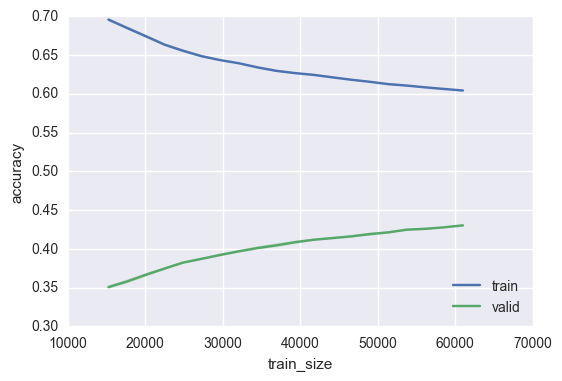

In [106]:
plot_learning_curve(val_train, val_test, n_train, xlabel='train_size', ylabel='accuracy')

ВЫВОД: Новые размеченные данные помогут